**План проекта прогнозирования дефолта**
* [1 Описание данных](#data_description)
* [2 Обработка выбросов](#outlier)
    * [2.1 Current Loan Amount](#Loan_Amount)
    * [2.2 Maximum Open Credit](#Max_Credit)
    * [2.3 Credit Score](#Score)
* [3 Замена пропущенных значений](#mis_val_base)
* [4 DataPreprocessing](#DataPreprocessing)   
* [5 Создание нового признака](#new_feat)
* [6 Построение модели](#modeling)

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, GridSearchCV

from scipy.stats import chi2_contingency

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
DATASET_PATH = 'data/course_project_train.csv'
TEST_PATH = 'data/course_project_test.csv'

In [4]:
def outlier(df, eps = 0.1, delta_threshold = 2, maxmin_threshold = 100000, paint=True):
    """
    Так как среднее арифметическое чувствительно к выбросам в отличии от медианы, 
    то можно по разности между ними судить о наличии выбросов в признаке. Кроме того,
    если максимальное значение во много раз больше минимального, то это также может
    говорить о наличии выбросов
    """
    columns = list(df.dtypes[df.dtypes != object].index)
    
    lst = []
    for col in columns:
        mn = df[col].mean()
        md = df[col].median() + eps
        maximum = df[col].max()
        minimum = df[col].min() + eps
        
        lst.append([col, mn, md, mn / md, maximum / minimum])
        
    mn_md_df = pd.DataFrame(lst, columns = ['Feature', 'mean', 'median', 'delta', 'max/min'])
    
    # Список признаков, где вероятнее всего есть выбросы
    features = list(mn_md_df['Feature'][mn_md_df.delta > delta_threshold]) + \
    list(mn_md_df['Feature'][mn_md_df['max/min'] > maxmin_threshold])
    
    # гистограмма признаков с возможными выбросами
    if paint:
        df[features].hist(log=True, figsize=(16,16)) 
        
    return (mn_md_df.sort_values(by='delta', ascending=False), features)

In [5]:
def feat_imp_draw(X, y, model=RandomForestRegressor(random_state=28, n_jobs=-1)):
    rf_model = model
    ab = range(len(X.columns), 0, -1)
    ordi = []
    cv_score_dt = cross_val_score(rf_model, X, y, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=28))
    ordi.append(np.mean(cv_score_dt))

    rf_model.fit(X, y)
    feature_importances = pd.DataFrame(zip(X.columns, rf_model.feature_importances_), 
                                       columns=['feature_name', 'importance'])
    df = feature_importances.sort_values(by='importance', ascending=False)

    for num in range(1, len(X.columns)):
        cv_score_dt = cross_val_score(rf_model, X[df[:-num].feature_name], y, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=28))
        ordi.append(np.mean(cv_score_dt))

    plt.plot(ab, ordi)
    plt.show()

    return df

In [6]:
def feature_info(df):
    # Малоинформативными считаем предикторы-выбросы либо по мощности (ось Х) 
    # либо по соотношению частот (ось Y)
    
    res = pd.DataFrame(df.columns, columns=['features'])
    
    # соотношение частот самого популярного значения относительно второго значения по частотности
    res['freqRation'] = 0
    
    # мощность или cardinality — доля уникального числа значений от общего числа значений
    res['percentUnique'] = 0
    
    for col in res.features:
        lst = list(df[col].value_counts().sort_values(ascending=False))
        res.loc[res.features == col, 'freqRation'] = lst[0] / lst[1]
        
        res.loc[res.features == col, 'percentUnique'] = 100 * len(df[col].unique()) / len(df)
        
    # Create as many colors as there are features
    categories = res['features']
    colors = [plt.cm.tab10(i/float(len(categories)-1)) for i in range(len(categories))]

    # Draw Plot for Each Category
    plt.figure(figsize=(16, 10), dpi= 80, facecolor='w', edgecolor='k')

    for i, category in enumerate(categories):
        plt.scatter('percentUnique', 'freqRation', data=res.loc[res.features==category, :], 
                s=20, c=np.array([colors[i]]), label=str(category))
       
        
    # Decorations
    plt.gca().set(xlabel='percentUnique', ylabel='freqRation', xscale='log', yscale='log')

    plt.xticks(fontsize=12); plt.yticks(fontsize=12)
    #plt.title("", fontsize=22)
    plt.legend(fontsize=12, ncol = 2)    
    plt.show()  

    return res

In [7]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

## 1. Описание данных <a class='anchor' id='data_description'>

In [8]:
df = pd.read_csv(DATASET_PATH)

In [9]:
df.head(10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
5,Rent,NaN,7 years,0.0,12.0,14.6,366784.0,0.0,NaN,0.0,other,Long Term,337304.0,165680.0,18692.0,NaN,1
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,99999999.0,51623.0,2317.0,745.0,0
7,Rent,1040060.0,10+ years,0.0,13.0,12.0,330374.0,0.0,18.0,0.0,other,Short Term,250888.0,89015.0,19761.0,705.0,1
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0
9,Home Mortgage,NaN,1 year,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,NaN,1


In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Annual Income,5943.0,1.366392e+06,8.453392e+05,164597.0,844341.0,1168386.0,1640137.00,1.014934e+07
Tax Liens,7500.0,3.013333e-02,2.716035e-01,0.0,0.0,0.0,0.00,7.000000e+00
Number of Open Accounts,7500.0,1.113093e+01,4.908924e+00,2.0,8.0,10.0,14.00,4.300000e+01
Years of Credit History,7500.0,1.831747e+01,7.041946e+00,4.0,13.5,17.0,21.80,5.770000e+01
Maximum Open Credit,7500.0,9.451537e+05,1.602622e+07,0.0,279229.5,478159.0,793501.50,1.304726e+09
Number of Credit Problems,7500.0,1.700000e-01,4.985978e-01,0.0,0.0,0.0,0.00,7.000000e+00
Months since last delinquent,3419.0,3.469260e+01,2.168881e+01,0.0,16.0,32.0,50.00,1.180000e+02
Bankruptcies,7486.0,1.171520e-01,3.471917e-01,0.0,0.0,0.0,0.00,4.000000e+00
Current Loan Amount,7500.0,1.187318e+07,3.192612e+07,11242.0,180169.0,309573.0,519882.00,1.000000e+08
Current Credit Balance,7500.0,2.898332e+05,3.178714e+05,0.0,114256.5,209323.0,360406.25,6.506797e+06


In [11]:
df.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

**Распределение целевого признака**

<AxesSubplot:>

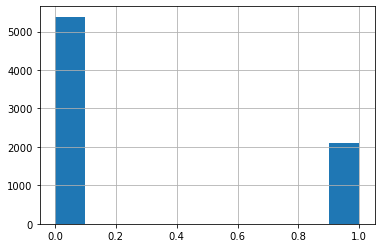

In [12]:
df['Credit Default'].hist()

Выборка несбалансирована

**Распределение категориальных признаков**

--------------------
Home Ownership
Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64


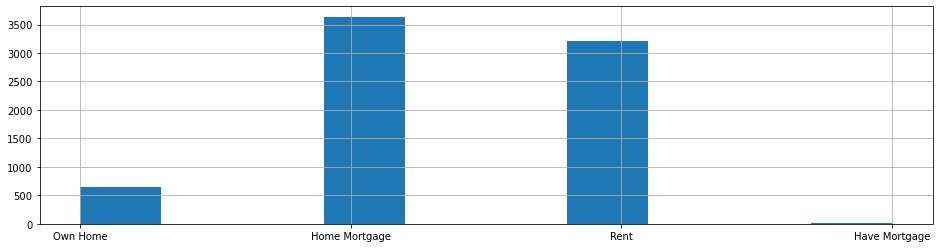

--------------------
Years in current job
10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64


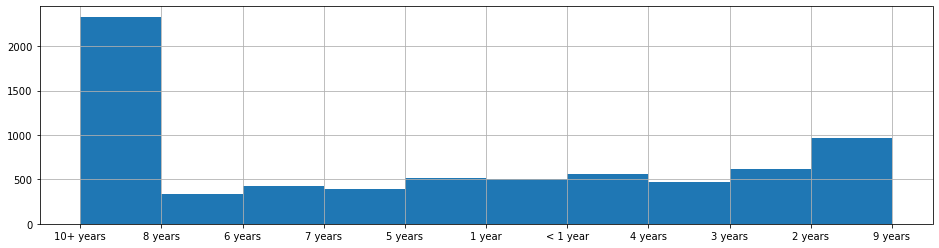

--------------------
Purpose
debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64


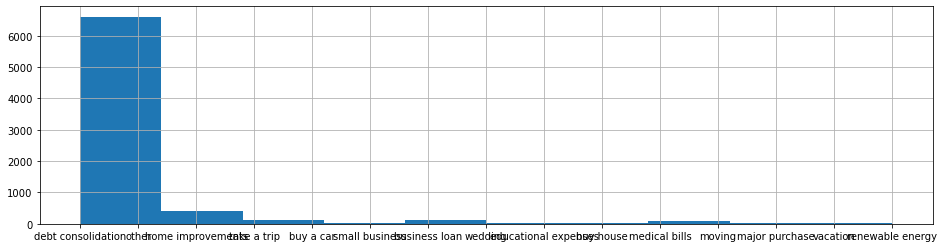

--------------------
Term
Short Term    5556
Long Term     1944
Name: Term, dtype: int64


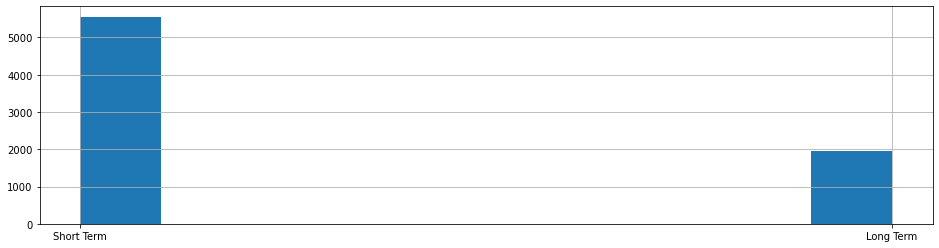

In [13]:
cat_features = list(df.dtypes[df.dtypes == 'object'].index)

for ftr in cat_features:
    print('--------------------')
    print(ftr)
    print(df[ftr].value_counts())
    plt.figure(figsize=(16, 4))
    df[ftr].hist()
    plt.show()

## 2 Обработка выбросов  <a class='anchor' id='outlier'>

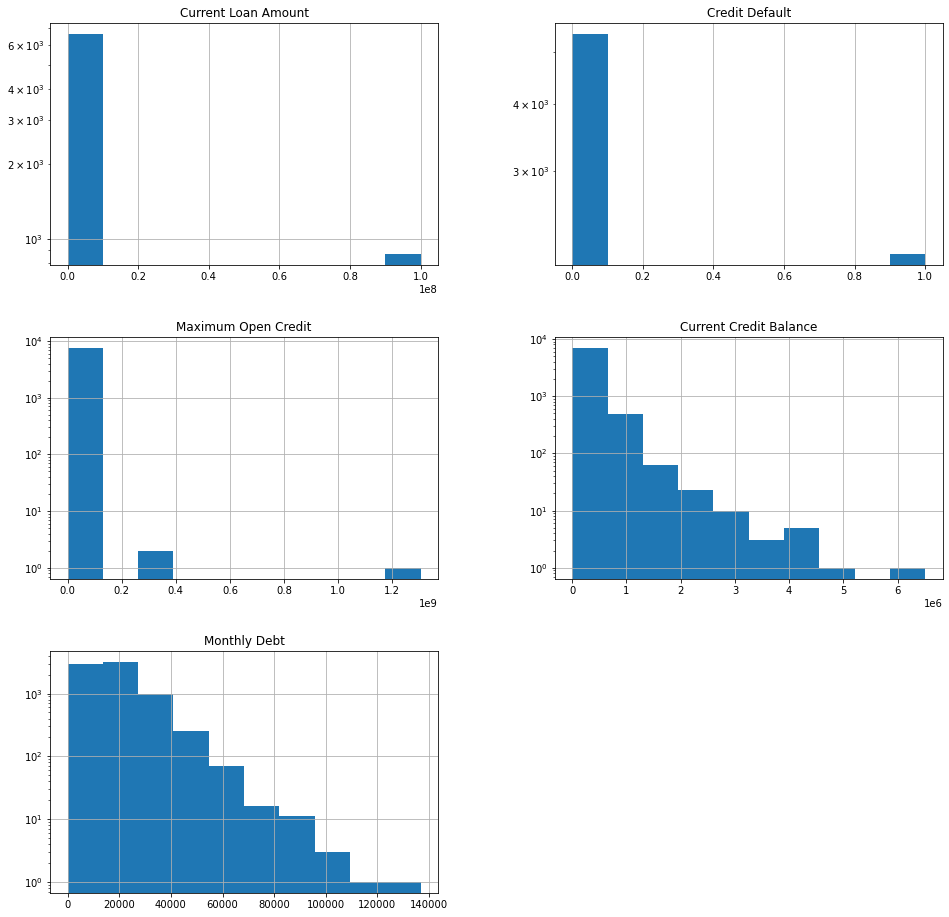

In [14]:
out = outlier(df)

In [15]:
out[0]

,Feature,mean,median,delta,max/min
8,Current Loan Amount,1.187318e+07,309573.1,38.353389,8.895135e+03
12,Credit Default,2.817333e-01,0.1,2.817333,1.000000e+01
4,Maximum Open Credit,9.451537e+05,478159.1,1.976651,1.304726e+10
5,Number of Credit Problems,1.700000e-01,0.1,1.700000,7.000000e+01
11,Credit Score,1.151087e+03,731.1,1.574460,1.283541e+01
9,Current Credit Balance,2.898332e+05,209323.1,1.384621,6.506797e+07
7,Bankruptcies,1.171520e-01,0.1,1.171520,4.000000e+01
0,Annual Income,1.366392e+06,1168386.1,1.169469,6.166174e+01
10,Monthly Debt,1.831445e+04,16076.6,1.139199,1.366790e+06
2,Number of Open Accounts,1.113093e+01,10.1,1.102073,2.047619e+01


Судя по гистограммам признаков с возможными выбросами, они есть у двух признаков точно ('Current Loan Amount', 'Maximum Open Credit') и, возможно, у 'Current Credit Balance'

In [16]:
out[1]

['Current Loan Amount',
 'Credit Default',
 'Maximum Open Credit',
 'Current Credit Balance',
 'Monthly Debt']

In [17]:
def new_df(df):
       
    le = LabelEncoder()
    for cat in cat_features:
        df[cat].fillna('NULL', inplace=True)
        le.fit(df[cat])

        df[cat] = le.transform(df[cat])
    return df    

In [18]:
temp_df = new_df(df)
temp_df.head().T

,0,1,2,3,4
Home Ownership,2.0,2.0,1.0,2.0,3.0
Annual Income,482087.0,1025487.0,751412.0,805068.0,776264.0
Years in current job,11.0,1.0,8.0,6.0,8.0
Tax Liens,0.0,0.0,0.0,0.0,0.0
Number of Open Accounts,11.0,15.0,11.0,8.0,13.0
Years of Credit History,26.3,15.3,35.0,22.5,13.6
Maximum Open Credit,685960.0,1181730.0,1182434.0,147400.0,385836.0
Number of Credit Problems,1.0,0.0,0.0,1.0,1.0
Months since last delinquent,NaN,NaN,NaN,NaN,NaN
Bankruptcies,1.0,0.0,0.0,1.0,0.0


### 2.1 'Current Loan Amount'  <a class='anchor' id='Loan_Amount'>

<AxesSubplot:>

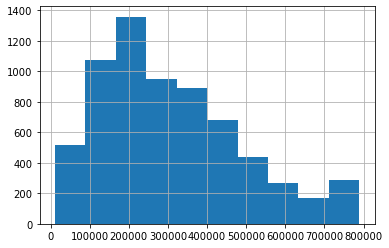

In [19]:
temp_df['Current Loan Amount'][temp_df['Current Loan Amount'] <= 1000000.00].hist()

<AxesSubplot:>

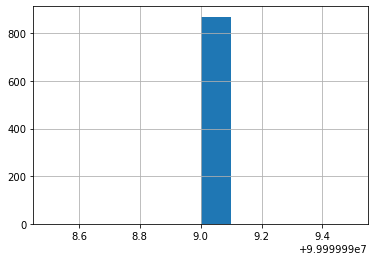

In [20]:
temp_df['Current Loan Amount'][temp_df['Current Loan Amount'] > 1000000.00].hist()

In [21]:
corr_matrix = temp_df.corr()

corr_matrix['Current Loan Amount'].sort_values(ascending=False)

Current Loan Amount             1.000000
Term                            0.075222
Annual Income                   0.032082
Current Credit Balance          0.016672
Years of Credit History         0.010623
Number of Open Accounts         0.001346
Months since last delinquent    0.000459
Maximum Open Credit            -0.002334
Years in current job           -0.003971
Purpose                        -0.005547
Bankruptcies                   -0.005987
Tax Liens                      -0.007835
Number of Credit Problems      -0.008596
Monthly Debt                   -0.009382
Home Ownership                 -0.015400
Credit Score                   -0.108552
Credit Default                 -0.226522
Name: Current Loan Amount, dtype: float64

Значения признака больше 1000000 будем считать выбросом. Так как логично предположить, что сумма кредита зависит от дохода, то будем заменять выбросы
значениям медианы суммы кредита как у клиентов с теми же доходами. Реализована в классе DataPreprocessing

### 2.2 'Maximum Open Credit'  <a class='anchor' id='Max_Credit'>

С этим признаком поступим аналогично предыдущему

<AxesSubplot:>

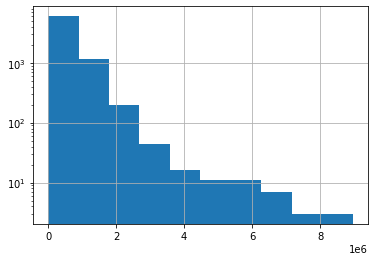

In [22]:
temp_df['Maximum Open Credit'][temp_df['Maximum Open Credit'] <= 9000000.00].hist(log=True)

<AxesSubplot:>

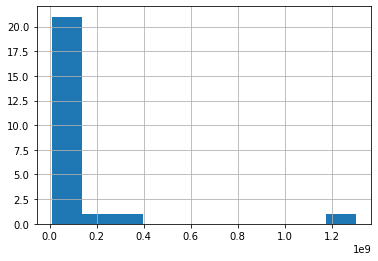

In [23]:
temp_df['Maximum Open Credit'][temp_df['Maximum Open Credit'] > 9000000.00].hist()

### 2.3 'Credit Score'  <a class='anchor' id='Score'>

<AxesSubplot:>

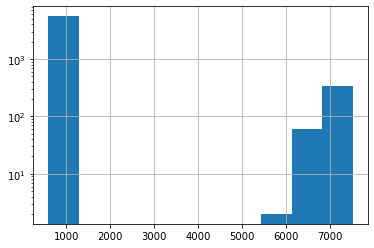

In [24]:
temp_df['Credit Score'].hist(log=True)

    Значения кредитного рейтинга больше 2000 поделим на 10

In [25]:
temp_df.loc[temp_df['Credit Score'] > 2000, 'Credit Score'] = temp_df['Credit Score'] / 10

<AxesSubplot:>

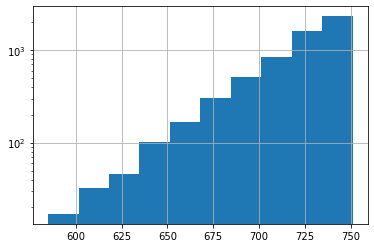

In [26]:
temp_df['Credit Score'].hist(log=True)

## 3 Замена пропущенных значений <a class='anchor' id='mis_val_base'>

In [27]:
df.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job               0
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

NAN признаков 
- 'Annual Income' заменим на медианы дохода подвыборок, сгруппированных по величине кредитной истории (что отражает возраст человека) и типа имеющегося имущества, 
- 'Years in current job' сделаем отдельной категорией, 
- 'Months since last delinquent', 'Bankruptcies' - нолями, 
- 'Credit Score' - на медианы рейтинга подвыборок, сгруппированных по величине кредитной истории и дохода.

Ниже показаны разбиения на категории признаков лительности кредитной истории и дохода 

In [28]:
temp_df['history_cat'] = np.ceil(temp_df['Years of Credit History'] / 8)
temp_df['history_cat'].where(temp_df['history_cat'] < 5, 5.0, inplace=True)
temp_df['history_cat'].value_counts()

2.0    3022
3.0    2945
4.0     970
5.0     351
1.0     212
Name: history_cat, dtype: int64

<AxesSubplot:>

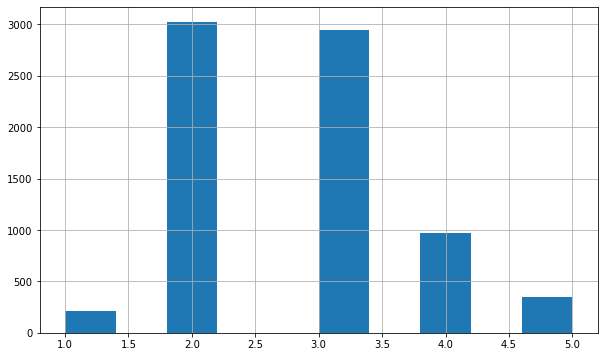

In [29]:
plt.figure(figsize=(10, 6))
temp_df['history_cat'].hist()

In [30]:
temp_df['income_cat'] = np.ceil(temp_df['Annual Income'] / 700000)
temp_df['income_cat'].where(temp_df['income_cat'] < 5, 5.0, inplace=True)
temp_df['income_cat'].value_counts()

2.0    2900
5.0    1866
3.0    1448
1.0     858
4.0     428
Name: income_cat, dtype: int64

<AxesSubplot:>

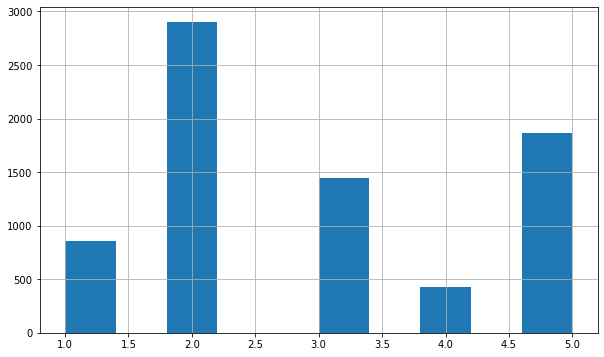

In [31]:
plt.figure(figsize=(10, 6))
temp_df['income_cat'].hist()

## 4 DataPreprocessing  <a class='anchor' id='DataPreprocessing'>

In [32]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
             
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        
        X['history_cat'] = np.ceil(X['Years of Credit History'] / 8)
        X['history_cat'].where(X['history_cat'] < 5, 5.0, inplace=True)
        
        X['income_cat'] = np.ceil(X['Annual Income'] / 700000)
        X['income_cat'].where(X['income_cat'] < 5, 5.0, inplace=True)
        
        le = LabelEncoder()
        cat_features = list(X.dtypes[X.dtypes == 'object'].index)
        for cat in cat_features:
            X[cat].fillna('NULL', inplace=True)
            le.fit(X[cat])
            X[cat] = le.transform(X[cat])
        
        return X
   

    def transform(self, X):
        """Трансформация данных"""
        
        # Борьба с выбросами
        # Current Loan Amount
        X['Loan_Amount_outlier'] = 0
        X.loc[(X['Current Loan Amount']  > 1000000.00), 'Loan_Amount_outlier'] = 1
        X['Current Loan Amount'][X['Current Loan Amount'] > 1000000.00] = np.nan

        X['Current Loan Amount'].fillna(X.groupby(['income_cat'])['Current Loan Amount']. \
                                        transform(lambda x: x.median()), inplace=True)
        
        # Maximum Open Credit
        X['Maximum_Credit_outlier'] = 0
        X.loc[(X['Maximum Open Credit']  > 9000000.00), 'Maximum_Credit_outlier'] = 1
        X['Maximum Open Credit'][X['Maximum Open Credit'] > 9000000.00] = np.nan

        X['Maximum Open Credit'].fillna(X.groupby(['income_cat'])['Maximum Open Credit']. \
                                        transform(lambda x: x.median()), inplace=True)
        
        # Credit Score
        X.loc[X['Credit Score'] > 2000, 'Credit Score'] = X['Credit Score'] / 10
        
        # Замена пропущенных значений
        # Annual Income
        X['Income_nan'] = X['Annual Income'].isna() * 1
        X['Annual Income'].fillna(X.groupby(['history_cat', 
                    'Home Ownership'])['Annual Income'].transform(lambda x: x.median()), inplace=True)
        
        # Months since last delinquent
        X['Months_nan'] = X['Months since last delinquent'].isna() * 1
        X['Months since last delinquent'].fillna(0, inplace=True)
        
        # Bankruptcies
        X['Bankruptcies_nan'] = X['Bankruptcies'].isna() * 1
        X['Bankruptcies'].fillna(0, inplace=True)
        
        # Credit Score
        X['Score_nan'] = X['Credit Score'].isna() * 1
        X['Credit Score'].fillna(X.groupby(['history_cat', 
                        'income_cat'])['Credit Score'].transform(lambda x: x.median()), inplace=True)
        
        
        
        X.fillna(self.medians, inplace=True)
        
        return X

In [33]:
preprocessor = DataPreprocessing()
preprocessor.fit(df)
temp_df = new_df(preprocessor.transform(df))

<ipython-input-32-a8f6ad036022>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Current Loan Amount'][X['Current Loan Amount'] > 1000000.00] = np.nan
<ipython-input-32-a8f6ad036022>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Maximum Open Credit'][X['Maximum Open Credit'] > 9000000.00] = np.nan


In [34]:
temp_df.isna().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
history_cat                     0
income_cat                      0
Loan_Amount_outlier             0
Maximum_Credit_outlier          0
Income_nan                      0
Months_nan                      0
Bankruptcies_nan                0
Score_nan                       0
dtype: int64

## 5 Создание нового признака <a class='anchor' id='new_feat'>

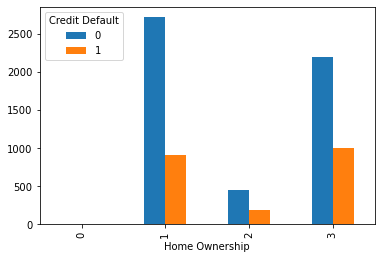

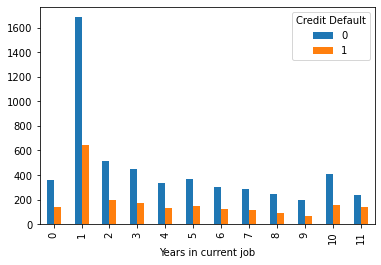

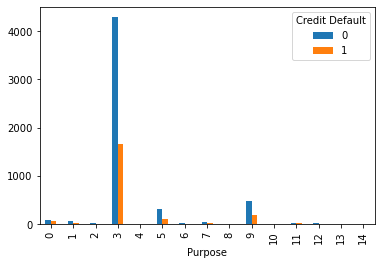

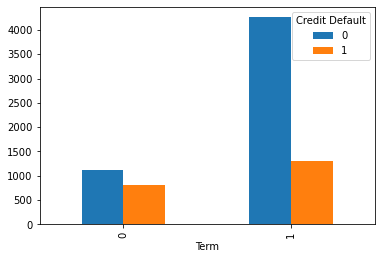

In [35]:
for col in cat_features:

    ct = pd.crosstab([df[col]], df['Credit Default'])
    ct.plot(kind='bar')

Последний признак кажется наиболее важным из всех остальных категориальных. Попробуем его сконпоновать с другими признаками

<AxesSubplot:xlabel='Term,Home Ownership'>

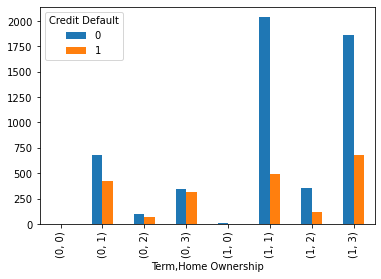

In [36]:
ct = pd.crosstab([df['Term'], df['Home Ownership']], df['Credit Default'])
ct.plot(kind='bar')

Можно сделать признак [(long term, rent) + (long term, own home)], [(short term, home mortgage) + (short term, own home) + (short term, rent)], [(long term, home mortgage)], остальные  

In [37]:
ct

Credit Default          0    1
Term Home Ownership           
0    0                  0    1
     1                682  427
     2                103   69
     3                343  319
1    0                 10    1
     1               2039  489
     2                352  123
     3               1858  684

* Нулевая гипотеза: ожидаемые и наблюдаемые частоты согласованы  [(short term, home mortgage) + (short term, own home) + (short term, rent)]
* Альтернативная гипотеза: отклонения в частотах выходят за рамки случайных колебаний, расхождения статистически значимы
* Критерий: Хи-квадрат Пирсона
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

In [38]:
ct2 = pd.crosstab([df['Term'][df['Term'] == 1], df['Home Ownership'][(df['Home Ownership'] == 1)\
                     | (df['Home Ownership'] == 2) | \
                                         (df['Home Ownership'] == 3)]], df['Credit Default'])
ct2

Credit Default          0    1
Term Home Ownership           
1    1               2039  489
     2                352  123
     3               1858  684

In [39]:
chi2, p, dof, expected = chi2_contingency(ct2, correction=False)
p

6.388059168698571e-10

P-value получилось ниже выбранного уровня значимости, значит H0 отбрасываем и из этой комбинации нельзя сделать признак. Попробуем убрать (short term, home mortgage)

In [40]:
ct2 = pd.crosstab([df['Term'][df['Term'] == 1], df['Home Ownership'][(df['Home Ownership'] == 2) | \
                                         (df['Home Ownership'] == 3)]], df['Credit Default'])
ct2

Credit Default          0    1
Term Home Ownership           
1    2                352  123
     3               1858  684

In [41]:
chi2, p, dof, expected = chi2_contingency(ct2, correction=False)
p

0.6470106469920326

(short term, own home) + (short term, rent) можно объединить в один признак

Следующая аналогичная гипотеза на основе [(long term, rent) + (long term, own home)]

In [42]:
ct3 = pd.crosstab([df['Term'][df['Term'] == 0], df['Home Ownership'][(df['Home Ownership'] == 2) | \
                                         (df['Home Ownership'] == 3)]], df['Credit Default'])
ct3

Credit Default         0    1
Term Home Ownership          
0    2               103   69
     3               343  319

In [43]:
chi2, p, dof, expected = chi2_contingency(ct3, correction=False)
p

0.05866475008441962

P-value получилось выше выбранного уровня значимости, значит, делаем признак

In [44]:
def new_feature(X):
    X['New_feature'] = 0
    
    X.loc[(X['Term'] == 1) & ((X['Home Ownership'] == 2) | (X['Home Ownership'] == 3)), 'New_feature'] = 1
    X.loc[(X['Term'] == 0) & ((X['Home Ownership'] == 2) | (X['Home Ownership'] == 3)), 'New_feature'] = 2
    X.loc[(X['Term'] == 0) & (X['Home Ownership'] == 1), 'New_feature'] = 3
    X.loc[(X['Term'] == 1) & (X['Home Ownership'] == 1), 'New_feature'] = 4
    X.loc[(X['Home Ownership'] == 0) & ((X['Term'] == 0) | (X['Term'] == 1)), 'New_feature'] = 5
    
    return X

In [45]:
temp_df = new_feature(temp_df)

In [46]:
temp_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Home Ownership,7500.0,1.939067e+00,0.956526,0.0,1.00,2.0,3.00,3.0
Annual Income,7500.0,1.330250e+06,762182.571495,164597.0,925485.25,1167930.0,1521140.00,10149344.0
Years in current job,7500.0,4.018667e+00,3.437658,0.0,1.00,3.0,7.00,11.0
Tax Liens,7500.0,3.013333e-02,0.271604,0.0,0.00,0.0,0.00,7.0
Number of Open Accounts,7500.0,1.113093e+01,4.908924,2.0,8.00,10.0,14.00,43.0
Years of Credit History,7500.0,1.831747e+01,7.041946,4.0,13.50,17.0,21.80,57.7
Maximum Open Credit,7500.0,6.377660e+05,635880.727594,0.0,279229.50,477400.0,790135.50,8947840.0
Number of Credit Problems,7500.0,1.700000e-01,0.498598,0.0,0.00,0.0,0.00,7.0
Months since last delinquent,7500.0,1.581520e+01,22.649441,0.0,0.00,0.0,29.00,118.0
Bankruptcies,7500.0,1.169333e-01,0.346904,0.0,0.00,0.0,0.00,4.0


## 6. Построение модели  <a class='anchor' id='modeling'>

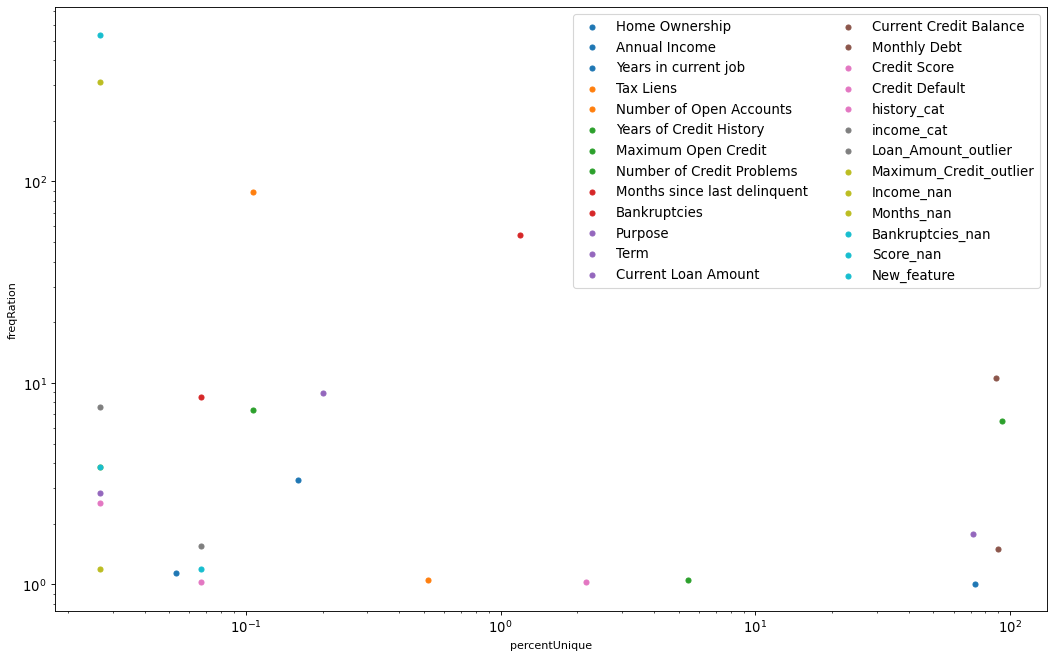

,features,freqRation,percentUnique
0,Home Ownership,1.135144,0.053333
1,Annual Income,1.008876,73.173333
2,Years in current job,3.307801,0.160000
3,Tax Liens,88.746988,0.106667
4,Number of Open Accounts,1.052023,0.520000
5,Years of Credit History,1.050505,5.440000
6,Maximum Open Credit,6.500000,92.573333
7,Number of Credit Problems,7.334467,0.106667
8,Months since last delinquent,53.934211,1.186667
9,Bankruptcies,8.491094,0.066667


In [47]:
feature_info(temp_df)

Скорее всего, признаки Current Credit Balance, Monthly Debt, Maximum Open Credit окажутся малополезными

In [48]:
def data_ready(X, split=True):
    preprocessor = DataPreprocessing()
    preprocessor.fit(X)
    df = new_df(preprocessor.transform(X))
    df = new_feature(df)
    
    y = df['Credit Default']
    X_ = df.drop(columns='Credit Default')
    if split:
        X_train, X_valid, y_train, y_valid = train_test_split(X_, y, test_size=0.25, shuffle=True, random_state=28, stratify=y)
        print('X_train, y_train, X_valid, y_valid, test_df shape', X_train.shape, y_train.shape,
              X_valid.shape, y_valid.shape)
        return X_train, y_train, X_valid, y_valid
    else:
        return X_, y

In [49]:
X_train, y_train, X_valid, y_valid = data_ready(df)

X_train, y_train, X_valid, y_valid, test_df shape (5625, 25) (5625,) (1875, 25) (1875,)


<ipython-input-32-a8f6ad036022>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Current Loan Amount'][X['Current Loan Amount'] > 1000000.00] = np.nan
<ipython-input-32-a8f6ad036022>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Maximum Open Credit'][X['Maximum Open Credit'] > 9000000.00] = np.nan


In [50]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))


def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [51]:
from catboost import CatBoostClassifier
model_catb = CatBoostClassifier(silent=True, random_state=28,
                                    class_weights=[1, 2.5],
                                    allow_writing_files=False,
                                    learning_rate=0.2,
                                    max_depth=3,
                                    n_estimators=1000,
                                    eval_metric='F1',
                                    reg_lambda=2.617721518987342,
                                    early_stopping_rounds=30,
                                    use_best_model=True,
                                    custom_metric=['Precision', 'Recall'],
                                    subsample=0.8,)
                                     
model_catb.fit(X_train, y_train, eval_set=(X_valid, y_valid))

In [52]:
evaluate_preds(model_catb, X_train, X_valid, y_train, y_valid)

TRAIN

              precision    recall  f1-score   support

           0       0.86      0.67      0.75      4040
           1       0.46      0.71      0.56      1585

    accuracy                           0.68      5625
   macro avg       0.66      0.69      0.65      5625
weighted avg       0.74      0.68      0.70      5625

TEST

              precision    recall  f1-score   support

           0       0.83      0.62      0.71      1347
           1       0.41      0.68      0.51       528

    accuracy                           0.64      1875
   macro avg       0.62      0.65      0.61      1875
weighted avg       0.71      0.64      0.65      1875



F:\DataSc\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


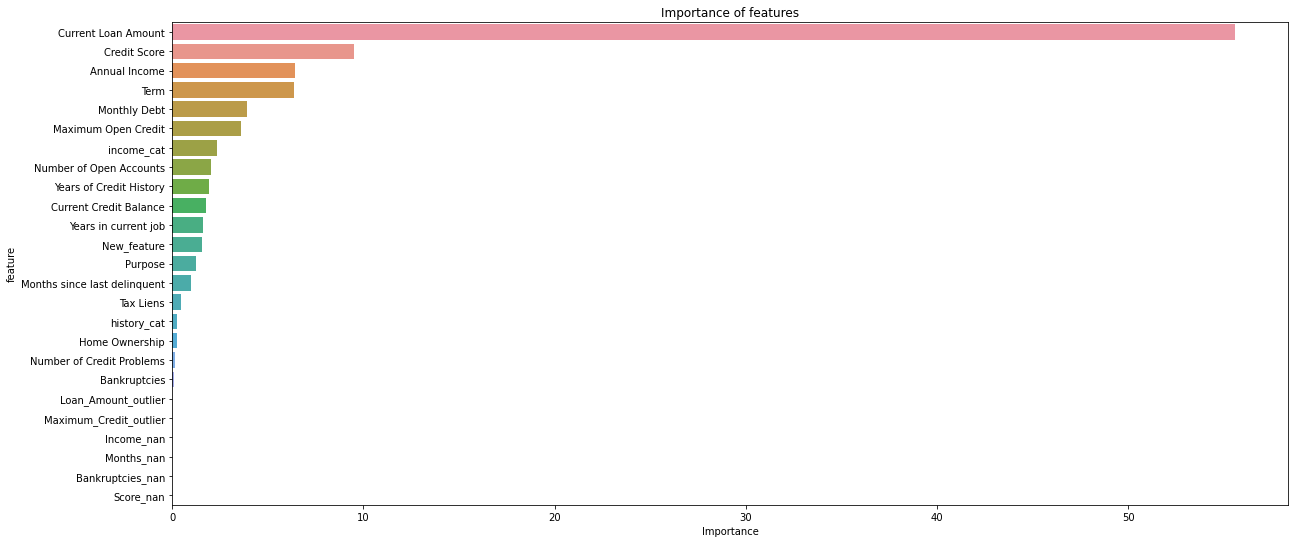

In [53]:
important_features_top = show_feature_importances(X_train.columns, model_catb.feature_importances_, get_top=18)

In [54]:
columns = important_features_top

In [55]:
model_catb.fit(X_train[columns], y_train, eval_set=(X_valid[columns], y_valid))

In [56]:
evaluate_preds(model_catb, X_train, X_valid, y_train, y_valid)

TRAIN

              precision    recall  f1-score   support

           0       0.87      0.68      0.77      4040
           1       0.48      0.75      0.58      1585

    accuracy                           0.70      5625
   macro avg       0.68      0.71      0.68      5625
weighted avg       0.76      0.70      0.71      5625

TEST

              precision    recall  f1-score   support

           0       0.83      0.62      0.71      1347
           1       0.41      0.67      0.51       528

    accuracy                           0.63      1875
   macro avg       0.62      0.64      0.61      1875
weighted avg       0.71      0.63      0.65      1875



F:\DataSc\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


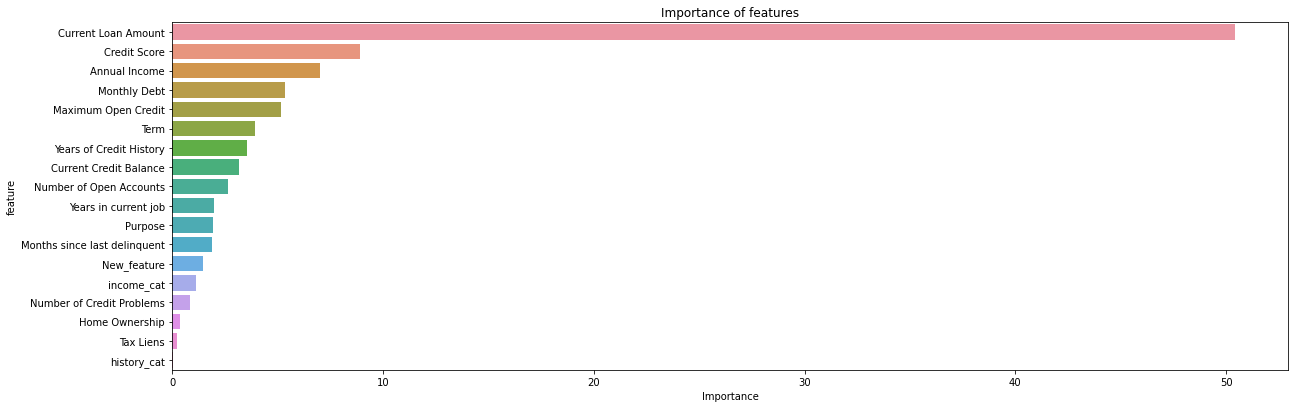

In [57]:
important_features_top = show_feature_importances(X_train[columns].columns, model_catb.feature_importances_, get_top=11)

In [58]:
columns = important_features_top

In [59]:
model_catb.fit(X_train[columns], y_train, eval_set=(X_valid[columns], y_valid))
evaluate_preds(model_catb, X_train, X_valid, y_train, y_valid)

TRAIN

              precision    recall  f1-score   support

           0       0.86      0.66      0.75      4040
           1       0.46      0.73      0.56      1585

    accuracy                           0.68      5625
   macro avg       0.66      0.69      0.65      5625
weighted avg       0.75      0.68      0.69      5625

TEST

              precision    recall  f1-score   support

           0       0.83      0.61      0.70      1347
           1       0.40      0.68      0.50       528

    accuracy                           0.63      1875
   macro avg       0.61      0.64      0.60      1875
weighted avg       0.71      0.63      0.64      1875



F:\DataSc\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


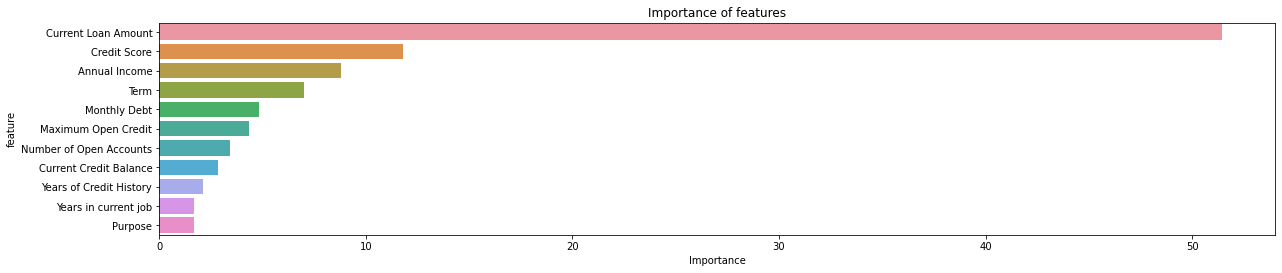

In [60]:
important_features_top = show_feature_importances(X_train[columns].columns, model_catb.feature_importances_)

In [61]:
X_test = pd.read_csv(TEST_PATH)

In [62]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_test)
df_test = preprocessor.transform(X_test)
df_test = new_feature(df_test)

<ipython-input-32-a8f6ad036022>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Current Loan Amount'][X['Current Loan Amount'] > 1000000.00] = np.nan
<ipython-input-32-a8f6ad036022>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Maximum Open Credit'][X['Maximum Open Credit'] > 9000000.00] = np.nan


In [63]:
predictions = model_catb.predict(df_test)
predictions = predictions.astype('int32')
predictions

array([1, 1, 0, ..., 0, 0, 1])

In [64]:
submit = pd.DataFrame(predictions, index=X_test.index, columns = ['Credit Default'])
submit

,Credit Default
0,1
1,1
2,0
3,1
4,1
...,...
2495,0
2496,0
2497,0
2498,0


In [65]:
submit.to_csv('VP_predictions.csv', index=False)